In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *
import random

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
random.seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size, identities_weight=0.028, identitity_weight_decay=0.96)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/15 | batch 2001/2000 | loss 1.1772 | val loss 0.7716 | acc 0.2131 | f1 0.3514 | prec 0.2131 | recall 1.0000 | roc auc 0.5159 | pr auc 0.2466 | elapsed 35.45s
train epoch 01/15 | batch 2001/2000 | loss 0.8565 | val loss 0.4719 | acc 0.8259 | f1 0.3815 | prec 0.7859 | recall 0.2519 | roc auc 0.6919 | pr auc 0.5177 | elapsed 101.94s
train epoch 02/15 | batch 2001/2000 | loss 0.5358 | val loss 0.3592 | acc 0.8611 | f1 0.5736 | prec 0.8292 | recall 0.4384 | roc auc 0.8336 | pr auc 0.7036 | elapsed 96.78s
train epoch 03/15 | batch 2001/2000 | loss 0.3829 | val loss 0.2952 | acc 0.8932 | f1 0.7017 | prec 0.8674 | recall 0.5891 | roc auc 0.8854 | pr auc 0.7985 | elapsed 88.36s
train epoch 04/15 | batch 2001/2000 | loss 0.2797 | val loss 0.2553 | acc 0.9101 | f1 0.7599 | prec 0.8825 | recall 0.6672 | roc auc 0.9111 | pr auc 0.8459 | elapsed 85.65s
train epoch 05/15 | batch 2001/2000 | loss 0.2122 

In [4]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'trained reasoner':
        train_mod(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger,identities_weight=0.045, identitity_weight_decay=0.9)
    #else:
        #train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 1251/1250 | loss 1.2322 | val loss 1.2157 | acc 0.6236 | f1 0.4000 | prec 0.3061 | recall 0.5772 | roc auc 0.6558 | pr auc 0.4710 | elapsed 19.57s
train epoch 01/10 | batch 1251/1250 | loss 1.0148 | val loss 0.7655 | acc 0.7265 | f1 0.4869 | prec 0.4111 | recall 0.5969 | roc auc 0.7464 | pr auc 0.5709 | elapsed 39.35s
train epoch 02/10 | batch 1251/1250 | loss 0.6491 | val loss 0.4871 | acc 0.8126 | f1 0.5984 | prec 0.5601 | recall 0.6424 | roc auc 0.8327 | pr auc 0.6879 | elapsed 40.89s
train epoch 03/10 | batch 1251/1250 | loss 0.4307 | val loss 0.3303 | acc 0.8723 | f1 0.7036 | prec 0.7099 | recall 0.6974 | roc auc 0.8963 | pr auc 0.7951 | elapsed 42.23s
train epoch 04/10 | batch 1251/1250 | loss 0.3077 | val loss 0.2430 | acc 0.9094 | f1 0.7820 | prec 0.8200 | recall 0.7475 | roc auc 0.9345 | pr auc 0.8680 | elapsed 42.06s
train epoch 05/10 | batch 1251/1250 | loss 0.2375 | val loss 0.1921 | acc 0.9304 | f1 0.8303 | prec 0.8831 | recall 0.

In [5]:
with T.no_grad():
    idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch_mod(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    #_, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240722T190137


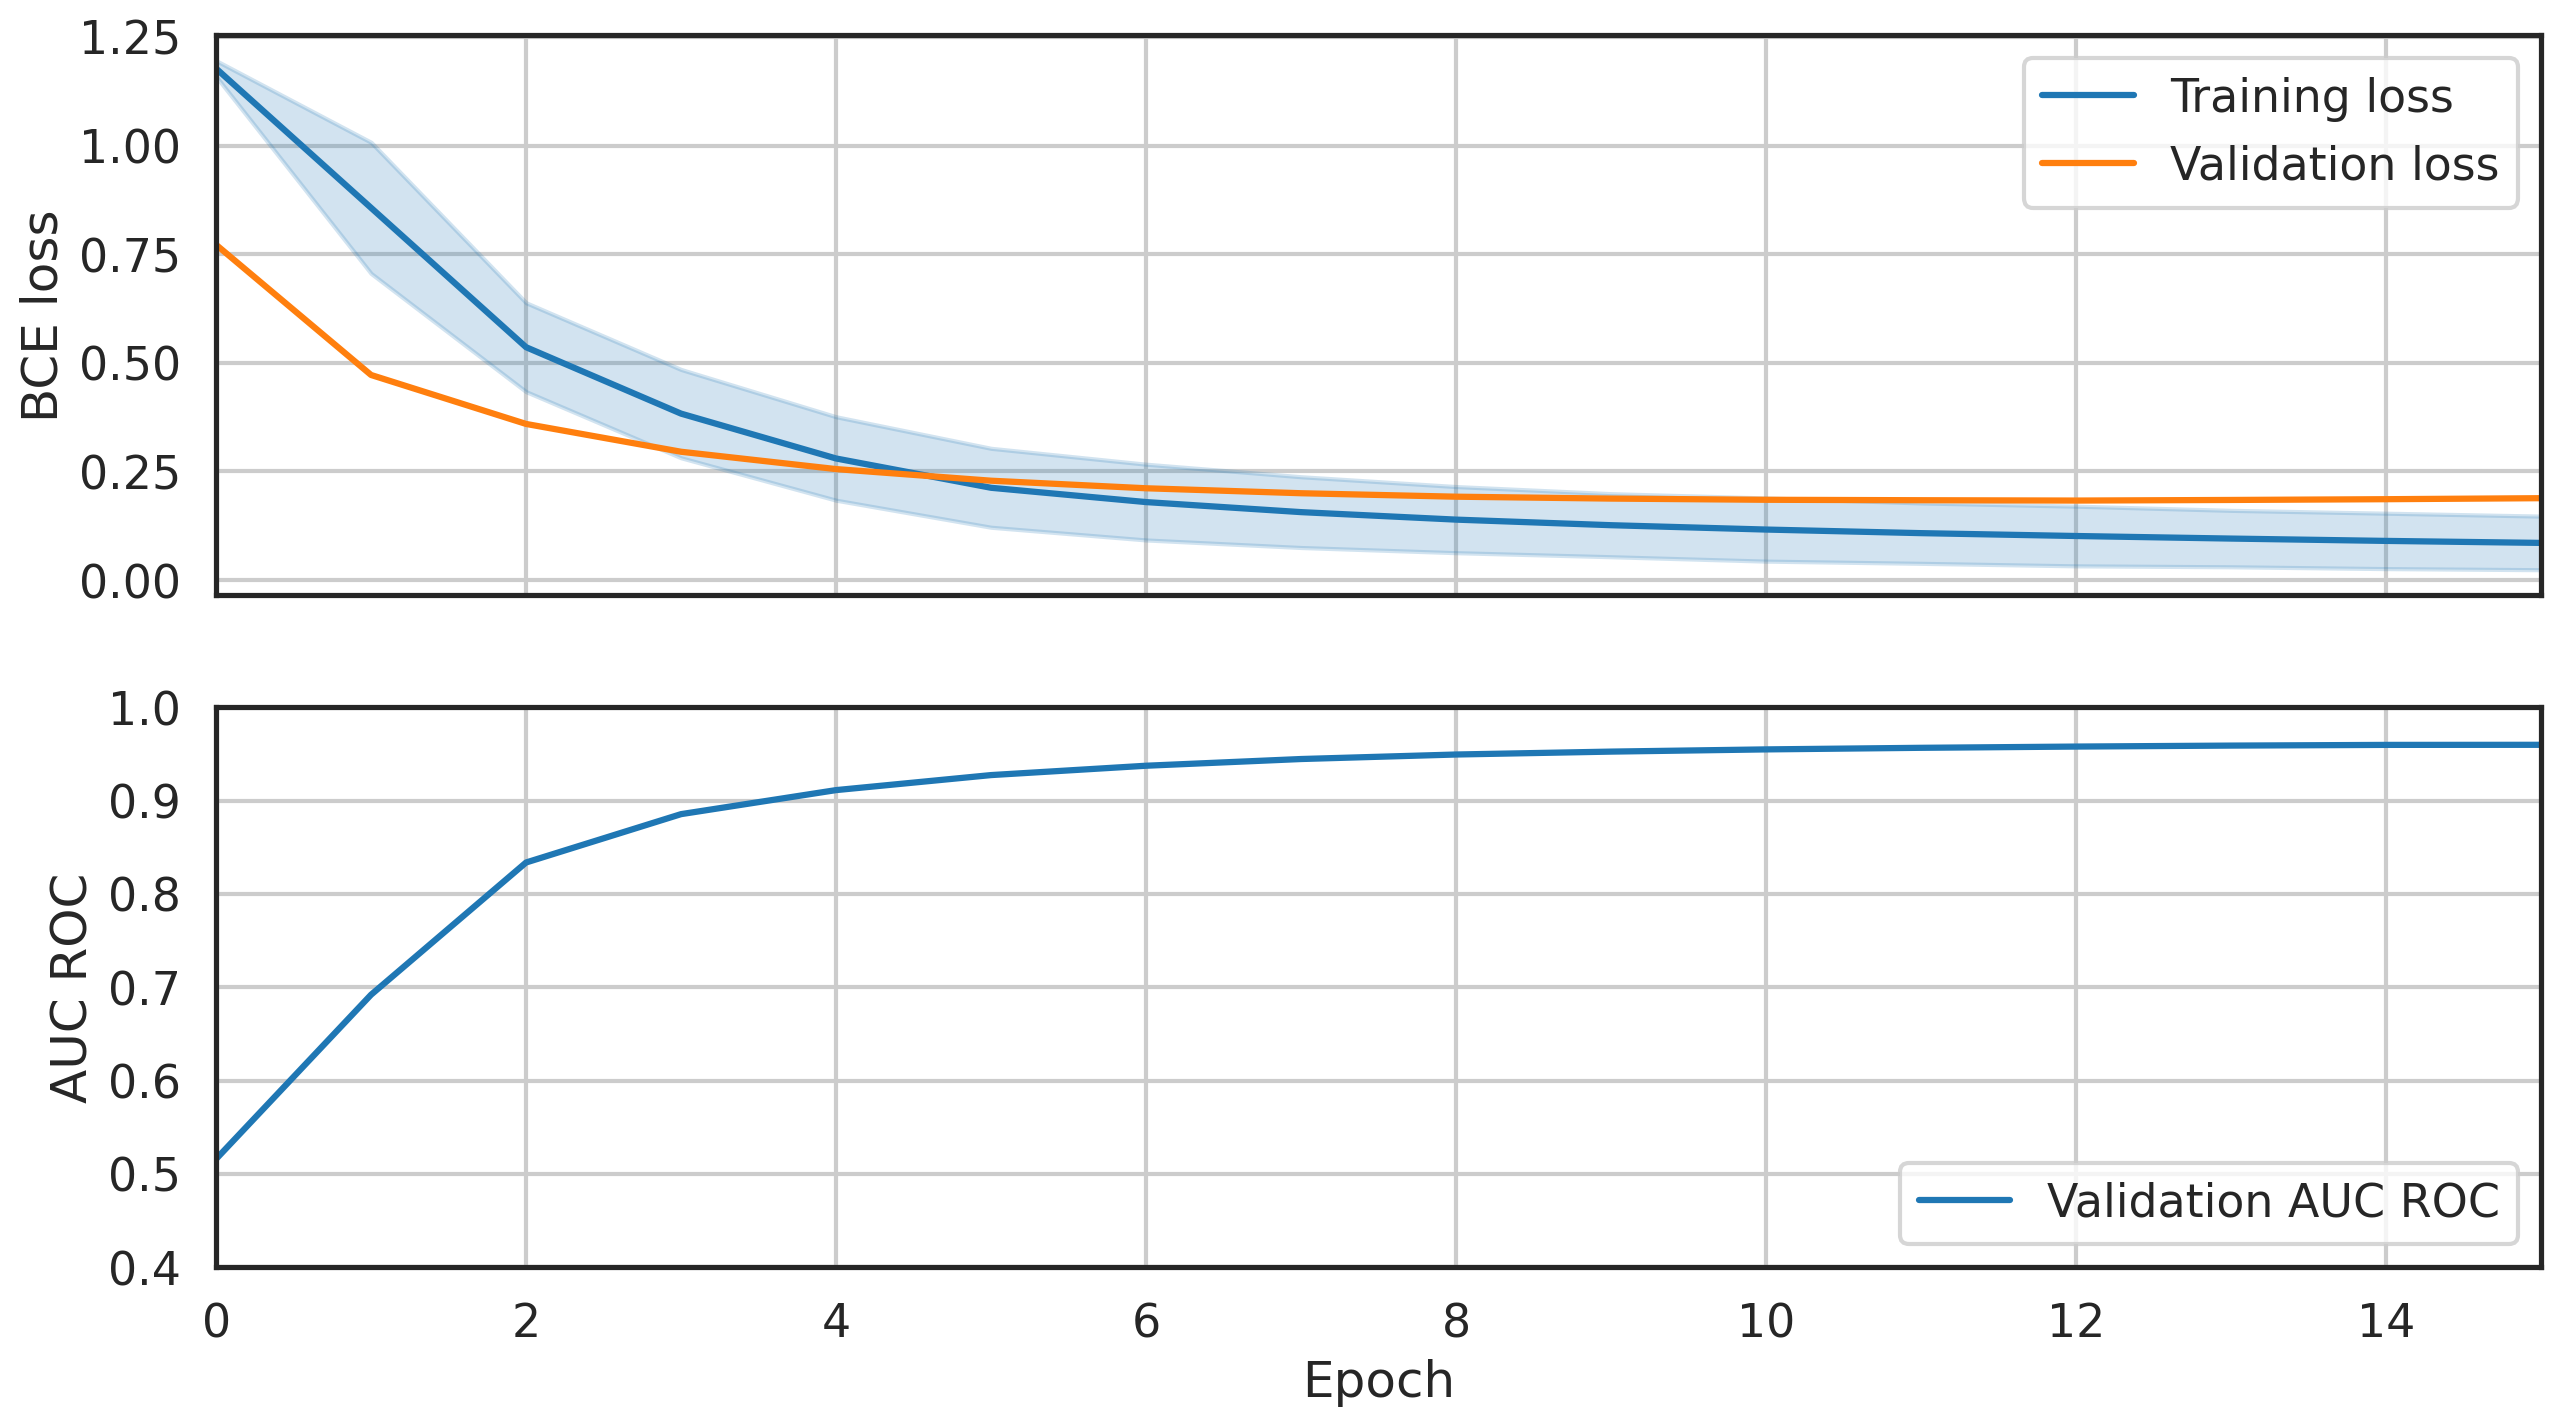

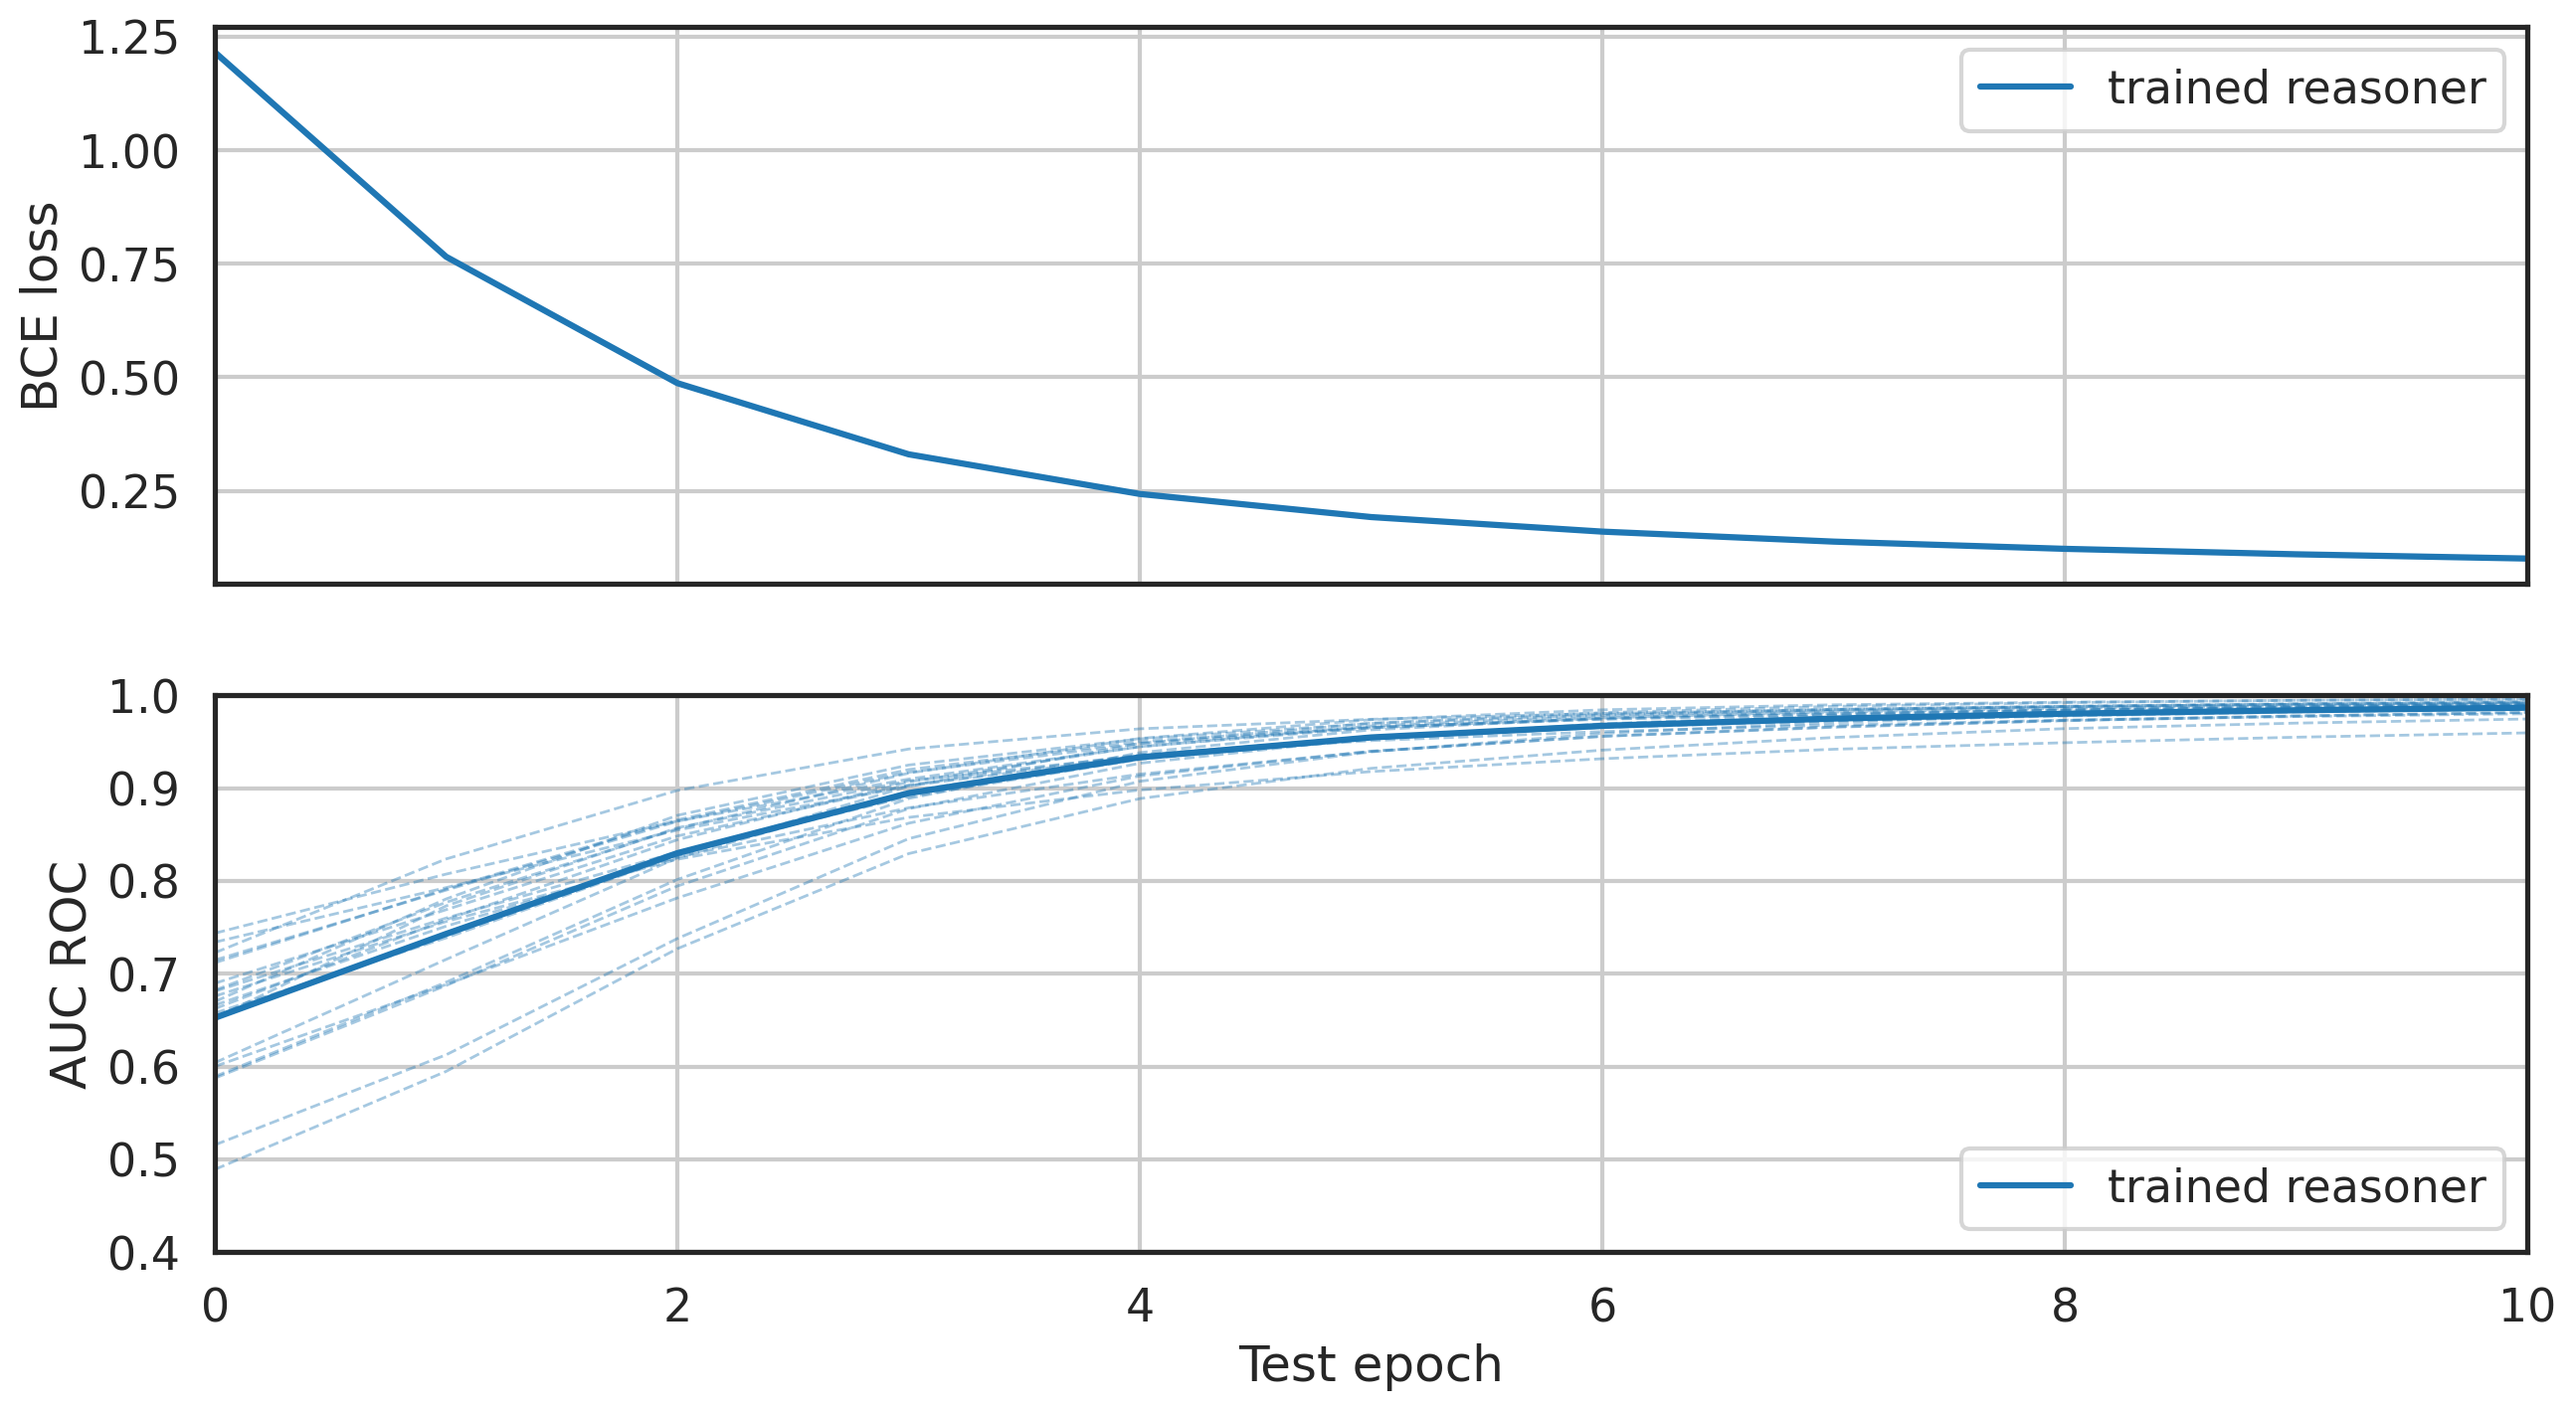

             mean       std     micro
acc      0.964450  0.015629  0.964450
prec     0.962595  0.028709  0.962840
recall   0.868387  0.047748  0.870055
f1       0.912767  0.037596  0.914099
auc_roc  0.986570  0.008419  0.987639
auc_pr   0.968893  0.017907  0.971535


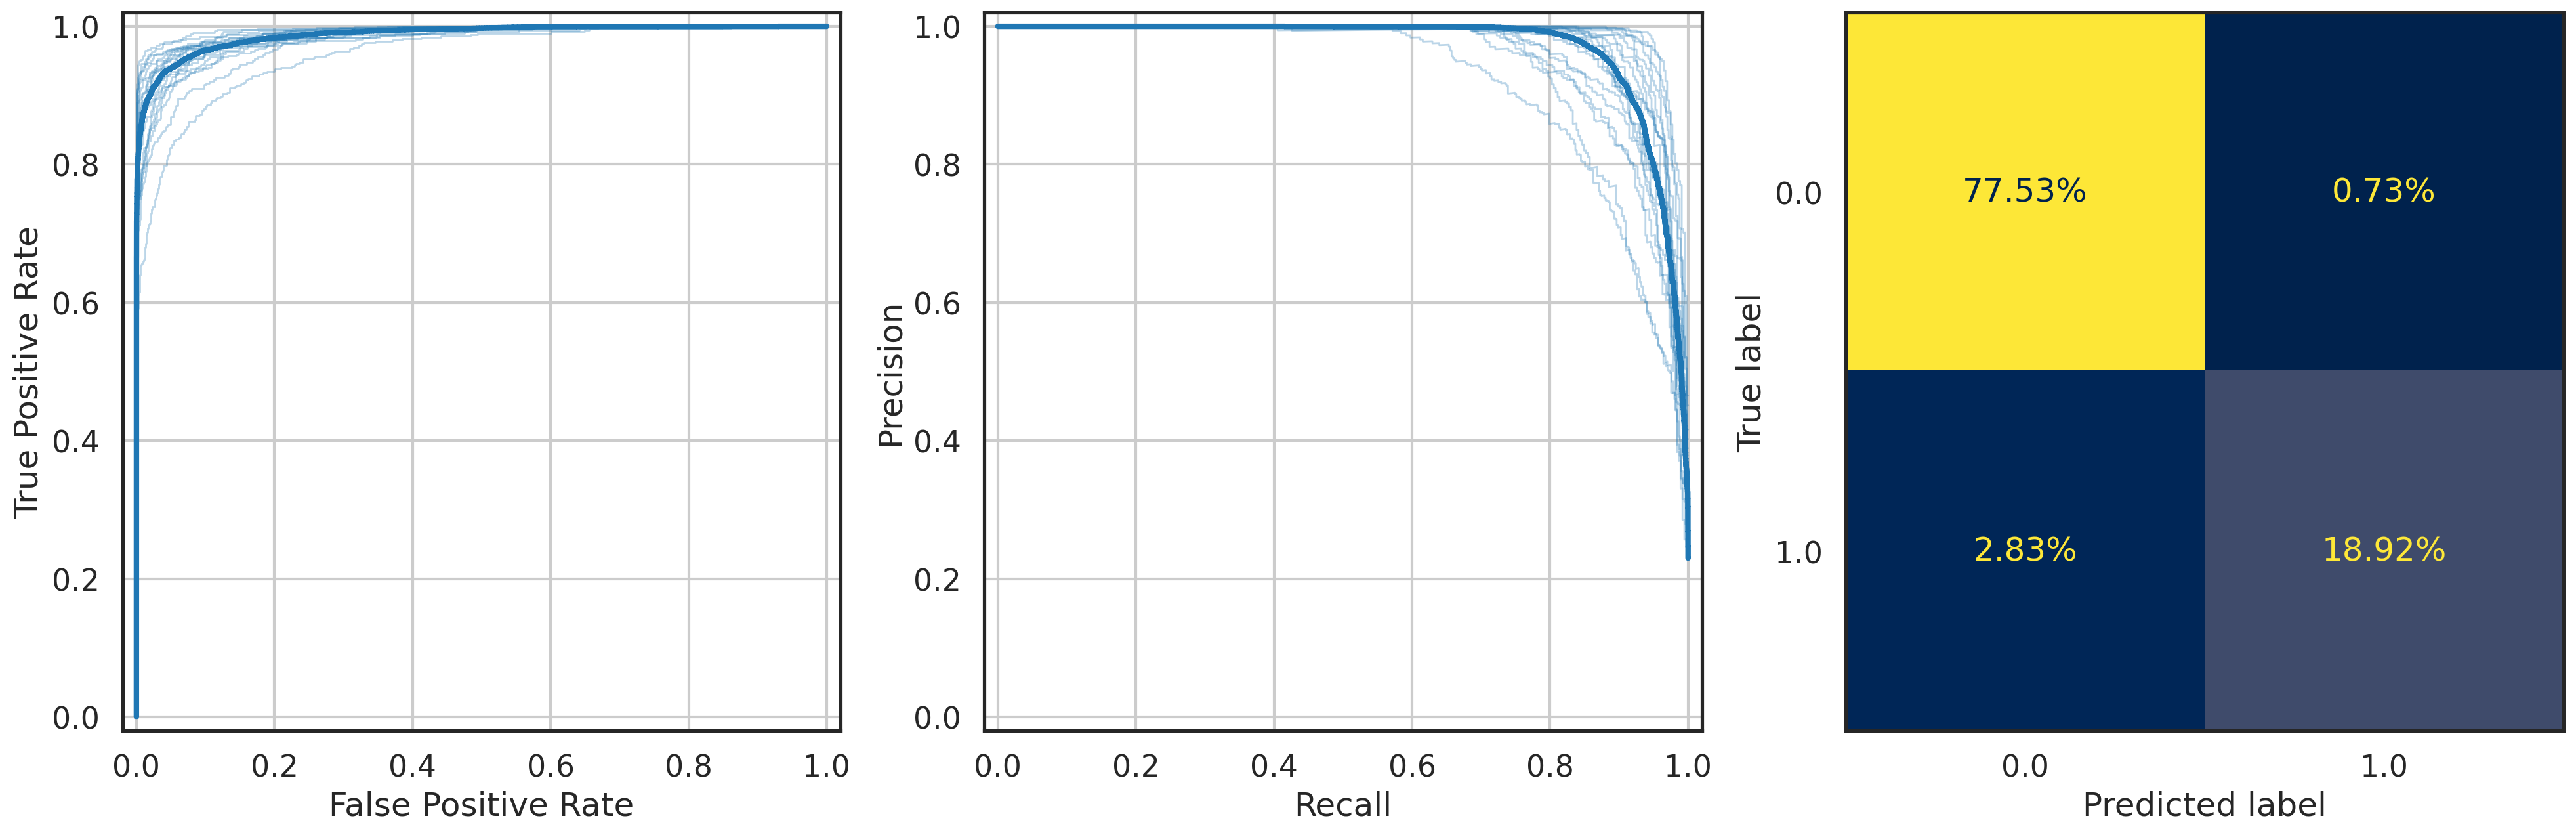

In [6]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good))#, Y_te_rand=Y_te_rand))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print(report(test_onto, y_te, np.array(Y_te_good), idx_te, save=base+'/%-trained'))
#print(report(test_onto, y_te, np.array(Y_te_rand), idx_te, save=base+'/%-random'))

In [7]:
def max_element_difference(tensor1, tensor2):
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensory muszą mieć ten sam kształt")
    diff = torch.abs(tensor1 - tensor2)
    max_diff = torch.max(diff).item()
    
    return max_diff

In [8]:
losses_double_negation = []
diffs_double_negation = []

losses_duality = []
diffs_duality = []

losses_duality.append( F.l1_loss(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])).item() )
diffs_duality.append(max_element_difference(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])))

losses_idempotence = []
diffs_idempotence = []
losses_associativity = []
diffs_associativity = []
losses_bot_concept_sub =[]
losses_commutativity = []
diffs_commutativity = []
losses_contradiction = []
diffs_contradiction = []
losses_identity_top = []
diffs_identity_top = []
losses_absorption_bottom = []
diffs_absorption_bottom = []
losses_top_subsumption = []
losses_reflexivity_subsumption = []

losses_bot_concept_self = []
diffs_bot_concept_self = []



for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    
    double_negation = trained_reasoner.not_nn(trained_reasoner.not_nn(input1))
    losses_double_negation.append( F.l1_loss(input1, double_negation).item() )
    diffs_double_negation.append(max_element_difference(input1, double_negation))


    idempotence = trained_reasoner.and_nn(im(input1, input1))
    losses_idempotence.append( F.l1_loss(input1, idempotence).item() )
    diffs_idempotence.append(max_element_difference(input1, idempotence))

    
    assoc_left = trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3))))
    assoc_right = trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))
    losses_associativity.append(F.l1_loss(assoc_left, assoc_right).item())
    diffs_associativity.append(max_element_difference(assoc_left, assoc_right))
    
    comm_left = trained_reasoner.and_nn(im(input1, input2))
    comm_right = trained_reasoner.and_nn(im(input2, input1))
    losses_commutativity.append(F.l1_loss(comm_left, comm_right).item())
    diffs_commutativity.append(max_element_difference(comm_left, comm_right))
    
    contradiction = trained_reasoner.and_nn(im(input1, trained_reasoner.not_nn(input1)))
    losses_contradiction.append(F.l1_loss(contradiction, trained_reasoner.bot_concept[0]).item())
    diffs_contradiction.append(max_element_difference(contradiction, trained_reasoner.bot_concept[0]))
    
    identity_top = trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_identity_top.append(F.l1_loss(identity_top, input1).item())
    diffs_identity_top.append(max_element_difference(identity_top, input1))
    
    absorption_bottom = trained_reasoner.and_nn(im(input1, trained_reasoner.bot_concept[0]))
    losses_absorption_bottom.append(F.l1_loss(absorption_bottom, trained_reasoner.bot_concept[0]).item())
    diffs_absorption_bottom.append(max_element_difference(absorption_bottom, trained_reasoner.bot_concept[0]))
    
    top_subsumption = trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_top_subsumption.append(1 - T.sigmoid(top_subsumption).item())
    
    losses_bot_concept_sub.append(1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], input1))).item())

    reflexivity_subsumption = trained_reasoner.sub_nn(im(input1, input1))
    losses_reflexivity_subsumption.append(1 - T.sigmoid(reflexivity_subsumption).item())

    losses_bot_concept_self.append( 1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item() )


In [9]:
import numpy as np

def print_results(name, losses, diffs):
    print(f"{name}:")
    print(f"  Mean Loss: {np.mean(losses):.6f}")
    print(f"  Std Dev Loss: {np.std(losses):.6f}")
    if diffs:
        print(f"  Mean Diff: {np.mean(diffs):.6f}")
        print(f"  Std Dev Diff: {np.std(diffs):.6f}")
    else:
        print("  Mean Diff: N/A")
        print("  Std Dev Diff: N/A")
    print()

# Print results for each identity
print_results("Double Negation", losses_double_negation, diffs_double_negation)
print_results("Duality of Top and Bottom", losses_duality, diffs_duality)
print_results("Idempotence", losses_idempotence, diffs_idempotence)
print_results("Associativity", losses_associativity, diffs_associativity)
print_results("Commutativity", losses_commutativity, diffs_commutativity)
print_results("Contradiction", losses_contradiction, diffs_contradiction)
print_results("Identity with Top", losses_identity_top, diffs_identity_top)
print_results("Absorption by Bottom", losses_absorption_bottom, diffs_absorption_bottom)
print_results("Top Concept Subsumption", losses_top_subsumption, [])
print_results("Bottom Concept Subsumption", losses_bot_concept_sub, [])
print_results("Reflexivity of Subsumption", losses_reflexivity_subsumption, [])
print_results("Bottom Concept Self-Subsumption", losses_bot_concept_self, [])


Double Negation:
  Mean Loss: 0.000009
  Std Dev Loss: 0.000004
  Mean Diff: 0.000021
  Std Dev Diff: 0.000008

Duality of Top and Bottom:
  Mean Loss: 0.000441
  Std Dev Loss: 0.000000
  Mean Diff: 0.001797
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.107134
  Std Dev Loss: 0.027686
  Mean Diff: 0.249109
  Std Dev Diff: 0.071225

Associativity:
  Mean Loss: 0.020813
  Std Dev Loss: 0.007271
  Mean Diff: 0.046916
  Std Dev Diff: 0.016212

Commutativity:
  Mean Loss: 0.024554
  Std Dev Loss: 0.008763
  Mean Diff: 0.057232
  Std Dev Diff: 0.021042

Contradiction:
  Mean Loss: 0.141339
  Std Dev Loss: 0.039340
  Mean Diff: 0.226419
  Std Dev Diff: 0.046875

Identity with Top:
  Mean Loss: 0.064547
  Std Dev Loss: 0.018585
  Mean Diff: 0.153026
  Std Dev Diff: 0.047743

Absorption by Bottom:
  Mean Loss: 0.018802
  Std Dev Loss: 0.009778
  Mean Diff: 0.042422
  Std Dev Diff: 0.017991

Top Concept Subsumption:
  Mean Loss: 0.001148
  Std Dev Loss: 0.001144
  Mean Diff: N/A
  Std De

In [10]:
losses_bot_concept_self =[]
for i in range(1000):
    losses_bot_concept_self.append( 1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item() )

print(np.mean(losses_bot_concept_self))
print(np.std(losses_bot_concept_self))

4.6133995056152344e-05
0.0


In [11]:
T.set_printoptions(precision=4)

In [12]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im_mod(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im_mod( input, input)))
print(np.mean(losses))

tensor([ 0.0732,  0.0405,  0.0586, -0.1328,  0.0184,  0.1055,  0.1809,  0.0795,
        -0.2422, -0.0742], grad_fn=<SelectBackward0>)
tensor([ 0.2493,  0.1817,  0.0318, -0.2578,  0.2955, -0.0215,  0.0823,  0.1103,
        -0.2333, -0.1131], grad_fn=<AddBackward0>)
0.10726572083681822


In [13]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.2763,  0.1928,  0.0123, -0.3400,  0.3575, -0.0439,  0.1033,  0.1101,
        -0.2622, -0.0839], grad_fn=<SelectBackward0>)
tensor([ 0.2871,  0.1745,  0.0190, -0.3376,  0.3864, -0.0506,  0.0994,  0.1295,
        -0.2630, -0.1072], grad_fn=<AddBackward0>)
0.01718291054200381


In [14]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([ 0.0248,  0.1735,  0.1436, -0.1845,  0.1787, -0.1427,  0.1269,  0.1381,
        -0.2132, -0.0630], grad_fn=<SelectBackward0>)
tensor([ 0.1371,  0.1179,  0.0756, -0.1490,  0.1900, -0.0779,  0.0630,  0.0833,
        -0.1501, -0.0654], grad_fn=<AddBackward0>)
0.07593219453655184


In [15]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im_mod(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.2763,  0.1928,  0.0123, -0.3400,  0.3575, -0.0439,  0.1033,  0.1101,
        -0.2622, -0.0839], grad_fn=<SelectBackward0>)
tensor([ 0.1010, -0.1101, -0.0394, -0.1637,  0.1517, -0.1565, -0.0774, -0.1317,
         0.0209,  0.0830], grad_fn=<AddBackward0>)
0.13704284301027655


In [16]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.2763,  0.1928,  0.0123, -0.3400,  0.3575, -0.0439,  0.1033,  0.1101,
        -0.2622, -0.0839], grad_fn=<SelectBackward0>)
tensor([ 0.2767,  0.1928,  0.0124, -0.3392,  0.3578, -0.0442,  0.1051,  0.1107,
        -0.2622, -0.0840], grad_fn=<SqueezeBackward3>)
tensor(0.0004, grad_fn=<L1LossBackward0>)


In [17]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-0.1530, -0.1990,  0.0399,  0.4579, -0.0100,  0.1381,  0.6627,  0.1155,
        -0.0464,  0.2997], grad_fn=<SelectBackward0>)
tensor([-0.1537, -0.1994,  0.0391,  0.4576, -0.0105,  0.1378,  0.6616,  0.1151,
        -0.0457,  0.2999], grad_fn=<SqueezeBackward3>)
tensor(0.0005, grad_fn=<L1LossBackward0>)


In [18]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))), trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))))
print(trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.0345, -0.1411, -0.0064, -0.1170,  0.0265, -0.1212, -0.1503, -0.1340,
         0.0753,  0.0921], grad_fn=<AddBackward0>)
tensor([ 0.0365, -0.1580, -0.0032, -0.0906,  0.0380, -0.1655, -0.1155, -0.1285,
         0.0407,  0.1085], grad_fn=<AddBackward0>)
0.0202411760953255


In [19]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im_mod(input1, input2)), trained_reasoner.and_nn(im_mod(input2, input1))).item())

print(trained_reasoner.and_nn(im_mod(input1, input2)))
print(trained_reasoner.and_nn(im_mod(input2, input1)))

print(np.mean(losses))

tensor([ 0.0110, -0.0861,  0.0871, -0.0802,  0.0389, -0.1460, -0.1090, -0.0388,
         0.0119,  0.0510], grad_fn=<AddBackward0>)
tensor([ 0.0128, -0.1236,  0.0202, -0.0332,  0.0246, -0.1300, -0.0922, -0.0625,
         0.0180,  0.0992], grad_fn=<AddBackward0>)
0.02438028153544292


In [20]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([ 0.0820, -0.0264, -0.0538,  0.0509,  0.1807,  0.0935, -0.2046, -0.1263,
         0.1492, -0.0317], grad_fn=<SelectBackward0>)
tensor([ 0.0398, -0.0282,  0.0023, -0.0048,  0.0618, -0.0247, -0.1009, -0.0431,
         0.0571,  0.0108], grad_fn=<AddBackward0>)
0.06467605349421501


In [21]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im_mod(input1, input1))).item())
print(np.mean(losses))

0.17400122076280242


In [22]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im_mod(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.998877962231636


In [23]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im_mod(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9999538660049438


In [24]:
losses = []
for _ in range(1000):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im_mod(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9999538660049438
